# Определение температуры стали

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План работы:
    
1. Импортируем данные, проведём исследовательский анализ данных
2. Проведём предобработку данных, и подготовим данные:

    1. Определим признаки, необходимые нам для нашей будущей модели
    2. Удалим ненужные данные, если найдем
    
3. Соединим все нужные данные в одну таблицу с признаками key
4. Будем использовать XGBoost, CatBoost, LightGBM, LinearRegression с подбором нужных параметров
5. Сравним полученные результаты наших моделей и выделим лучшую. В качестве метрики будем использовать MAE, она должна быть меньше 6
6. Проверим на тестовой выборке, и после этого, напишем отчёт

## 1. Исследовательский Анализ Данных

In [1]:
# Импортируем нужные библиотеки
import math
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from scipy import stats

SEED = 42
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
# Создадим класс, в котором будем хранить нужные функции
class DataScience:

    
    def sns_draw(self, data, param, bins=30):
        """Строит график с заранее заданными параметрами"""
        fig = plt.figure(figsize=(15, 6), dpi=80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        ax_main = fig.add_subplot(grid[:-1, :-1])
        ax_right = fig.add_subplot(grid[:-1, -1])  
        sns.distplot(data[param], ax=ax_main)
        sns.boxplot(data[param], ax=ax_right)
        ax_right.grid(axis='y')
        ax_main.set(title=param)
        ax_main.axvline(np.mean(data[param]), color='g', linestyle='--', label='Среднее')
        ax_main.axvline(np.median(data[param]), color='g', linestyle='-', label='Медиана')
        ax_main.legend()
        fig.show()
    
    
    def feature_importance_plot(self, importance, names, model_type):
        """Строит график, отображающий значимость признаков"""

        feature_importance = np.array(importance)
        feature_names = np.array(names)

        # Создание датафрейма с помощью словаря
        data = {'feature_names': feature_names, 'feature_importance': feature_importance}
        fi_df = pd.DataFrame(data)

        # Сортировка по важности признаков
        fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

        # Настройка вида графика
        plt.figure(figsize=(10, 8))
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        plt.title(model_type + 'Важность признаков')
        plt.xlabel('Важность признаков')
        plt.ylabel('Названия признаков')
        
        
    def fit(self, train_features, train_actuals):
        """Тренирует модель и находит лучшую с помощью GridSearchCV"""
        for name in models.keys():
            est = models[name]
            est_params = params[name]
            grid_search = GridSearchCV(estimator=est, param_grid=est_params, cv=5)
            grid_search.fit(train_features, train_actuals)
            train_predictions = grid_search.predict(features_train)
            predictions = grid_search.predict(features_test)
            result_list.append({
            'model': name,
            'train_mae_score': mean_absolute_error(target_train, train_predictions),
            'test_mae_score': mean_absolute_error(target_test, predictions),
            'best_params': grid_search.best_params_
            })
            
    
    def dataset_info(self, data):
        """Отображает информацию по датасету"""
        data.info()
        display(data.head(10))
        display(data.describe())
        print('Количество дубликатов:', data.duplicated().sum())
    
            
ds = DataScience()

In [3]:
# Загрузим данные
data_arc = pd.read_csv('datasets/data_arc.csv')
data_bulk = pd.read_csv('datasets/data_bulk.csv')
data_bulk_time = pd.read_csv('datasets/data_bulk_time.csv')
data_gas = pd.read_csv('datasets/data_gas.csv')
data_temp = pd.read_csv('datasets/data_temp.csv')
data_wire = pd.read_csv('datasets/data_wire.csv')
data_wire_time = pd.read_csv('datasets/data_wire_time.csv')

### `Data_arc Dataset` : Данные об электродах

In [4]:
# Выведем первоначальную информацию 
ds.dataset_info(data_arc)

- Имеем 14 876 строк, с 5 столбцами
- Необходимо будет изменить тип данных у "Начало нагрева дугой" и *"Конец нагрева дугой" на *datetime*
- Пропусков нет, дубликатов тоже
- Имеем аномальное значение "-715" Реактивной мощности. Скорее всего, ошибка измерения

In [5]:
# Изменим тип данных на datetime
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc.info()

In [6]:
# Посчитаем количество партий по количеству уникальных значений 'key'
len(data_arc['key'].unique())

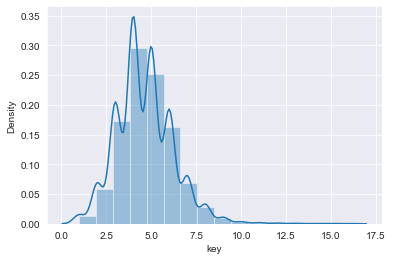

In [7]:
# Построим график 
sns.distplot(data_arc['key'].value_counts(), bins=16)
mode = stats.mode(data_arc['key'].value_counts())
print('Mode is:', mode[0][0])

`Key` - содержит номер партии
- Количество итераций обработки отличается для каждой партии от 1 до 16. Мода = 4

### Разберём, что такое активная и реактивная мощности:

- `Активная мощность (Real Power)`

    Единица измерения — ватт (русское обозначение: Вт, киловатт - кВт; международное: ватт -W, киловатт - kW).

    Среднее за период *Τ*  значение мгновенной мощности называется активной  мощностью, и

    выражается формулой:
    

$$ P =  {1 \over T} \int\limits_{0}^{T} p(t) dt $$



- `Реактивная мощность (Reactive Power)`

    Единица измерения — вольт-ампер реактивный (русское обозначение: вар, кВАР; международное: var).

    Реактивная мощность — величина, характеризующая нагрузки, создаваемые в электротехнических устройствах колебаниями энергии электромагнитного поля в цепи синусоидального переменного тока, равна произведению среднеквадратичных значений напряжения *U* и тока *I*, умноженному на синус угла сдвига фаз *φ* между ними:
    
    $$ Q = U * I * Sin\varphi $$
    
     (если ток отстаёт от напряжения, сдвиг фаз считается положительным, если опережает — отрицательным). Реактивная мощность связана с полной мощностью *S* и активной мощностью *P* соотношением:
     
     $$ | Q | = {\sqrt{S^2 - P^2}} $$
 
- `Полная мощность (Apparent Power)`

    Единица полной электрической мощности — вольт-ампер (русское обозначение: В·А, ВА, кВА-кило-вольт-ампер; международное: V·A, kVA).
    Полная мощность — величина, равная произведению действующих значений периодического электрического тока *I* в цепи и напряжения *U* на её зажимах:
    
    $$ S = U * I $$ 
    
    соотношение полной мощности с активной и реактивной мощностями выражается в следующем виде:
    
    $$  S  = {\sqrt{P^2 + Q^2}} $$
    
    где *P* — активная мощность, *Q* — реактивная мощность (при индуктивной нагрузке *Q*›0, а при ёмкостной *Q*‹0). Векторная зависимость между полной, активной и реактивной мощностью выражается формулой: 
    
    $$ \overrightarrow S = \overrightarrow P + \overrightarrow Q $$
    
    Полная мощность имеет практическое значение, как величина, описывающая нагрузки, фактически налагаемые потребителем на элементы подводящей электросети (провода, кабели, распределительные щиты, трансформаторы, линии электропередачи), так как эти нагрузки зависят от потребляемого тока, а не от фактически использованной потребителем энергии. Именно поэтому полная мощность трансформаторов и распределительных щитов измеряется в вольт-амперах, а не в ваттах.


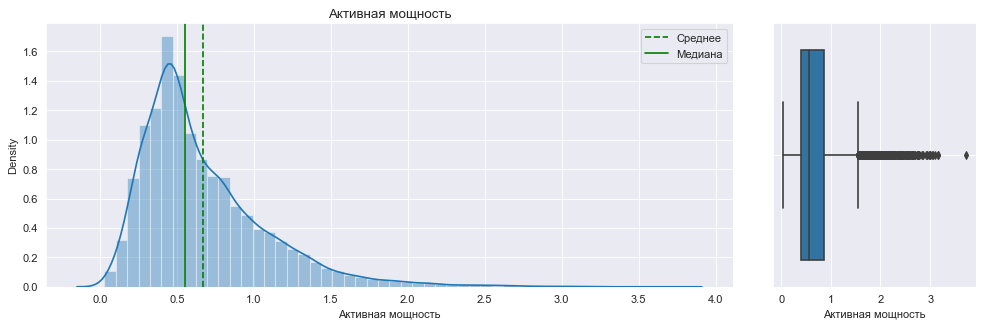

In [8]:
# Посмотрим на распределение активной мощности
ds.sns_draw(data_arc, 'Активная мощность')

- Распределение напоминает нормальное со сдвигом влево

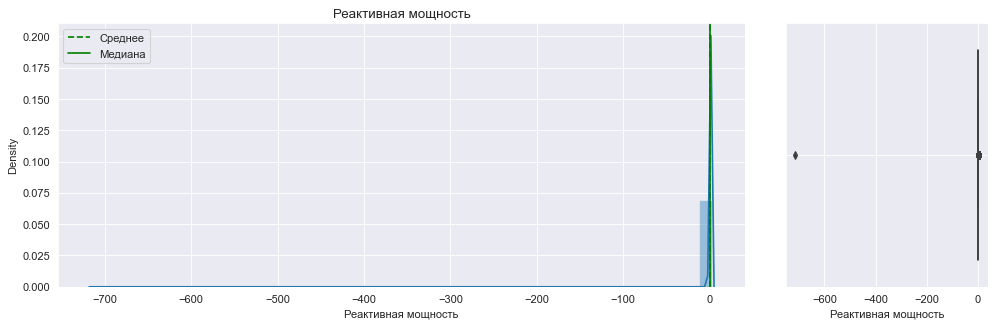

In [9]:
# Посмотрим на распределение реактивной мощности
ds.sns_draw(data_arc, 'Реактивная мощность')

- Видим аномальное значение реактивной мощности. Попробуем избавиться от него и посмотрим на результат

In [10]:
# Избавимся от выбросов меньше нуля
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]

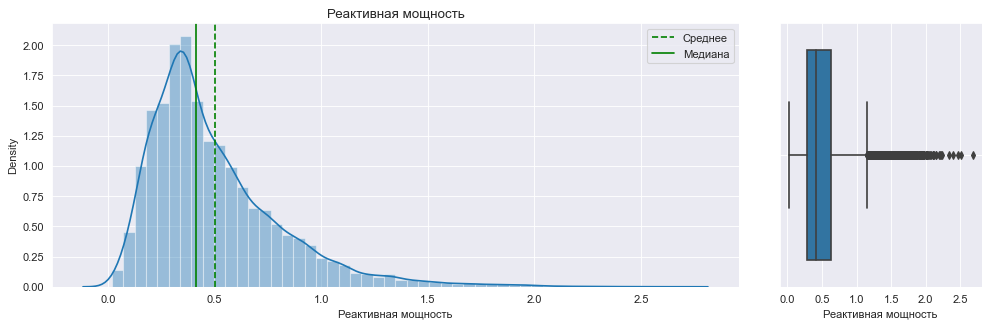

In [11]:
# Ещё раз посмотрим на распределение реактивной мощности после удаления выбросов
ds.sns_draw(data_arc, 'Реактивная мощность')

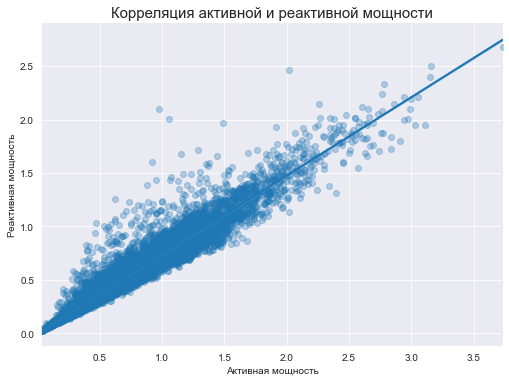

In [12]:
# Проверим корреляцию между активной и реактивной мощностями
print('Корреляция активной и реактивной мощности', data_arc['Активная мощность'].corr(data_arc['Реактивная мощность']))
plt.figure(figsize=(20,10))
sns.lmplot(x='Активная мощность', y='Реактивная мощность',data=data_arc, scatter_kws={'alpha':0.3}, aspect=14/10)
plt.title('Корреляция активной и реактивной мощности', fontsize=15)
plt.show();

Реактивная и активная мощности очень сильно коррелируют между собой. Возможна переобучаемость модели в дальнейшем. 

Имея данные по активной и реактивной мощности можем ввести новый признак "Полная мощность" по следующей формуле:

$$ S=\sqrt{P^2+Q^2} $$
где: $P$ — активная мощность, $Q$ — реактивная мощность

In [13]:
# Напишем функцию по расчёту Полной мощности
def full_power(row):
    full_power = math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power

In [14]:
data_arc['Полная мощность'] = data_arc.apply(full_power, axis=1)

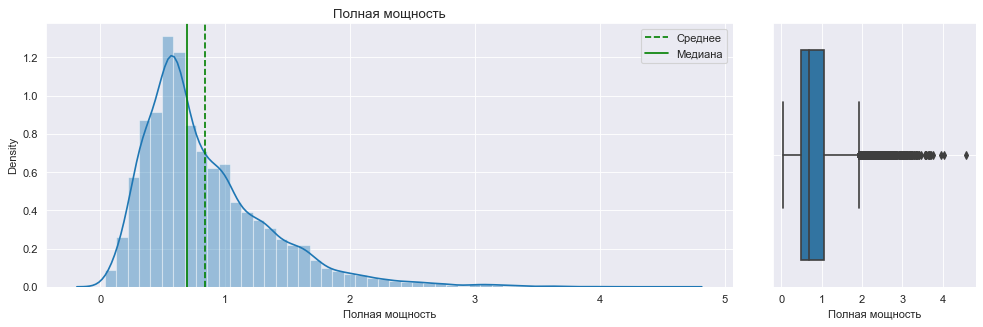

In [15]:
# Посмотрим на распределение Полной мощности
ds.sns_draw(data_arc, 'Полная мощность')

In [16]:
data_arc.head()

### Вывод:

- Изучили датасет data_arc
- Проверили на дубликаты и пустые значения. Их у нас не оказалось.
- Изменили типы данных на datetime в столбца "Начало нагрева дугой" и "Конец нагрева дугой"
- Избавились от аномальных значений "-715" в Реактивной мощности
- Разобрались, что такое активная и реактивная мощности. Так же из-за сильной корреляции между активной и реактивной мощностями, добавили новый признак "Полная мощность"

### `Data_Bulk Dataset` : Данные о подаче сыпучих материалов (объём);

In [17]:
ds.dataset_info(data_bulk)

In [18]:
#количество уникальных значений Key
len(data_bulk['key'].unique())

- Типы данных указаны верно. Дубликаты отсутствуют
- Видим большое количество пропущенных значений в датасете из-за того что для каждой партии добавляют опредленное сочетание сыпучих материалов

### Data_Bulk_time - Данные о подаче сыпучих материалов (время);

In [19]:
ds.dataset_info(data_bulk_time)

- Наблюдаем большое количество пропущенных значений в датасете
- Дубликатов не имеем, но имеются типы данных, которые нужно исправить
- В построении нашей будущей модели данный датасет использовать не будем, нет необходимости проводить его предобработку

### Data_gas - данные о продувке сплава газом;

In [20]:
ds.dataset_info(data_gas)

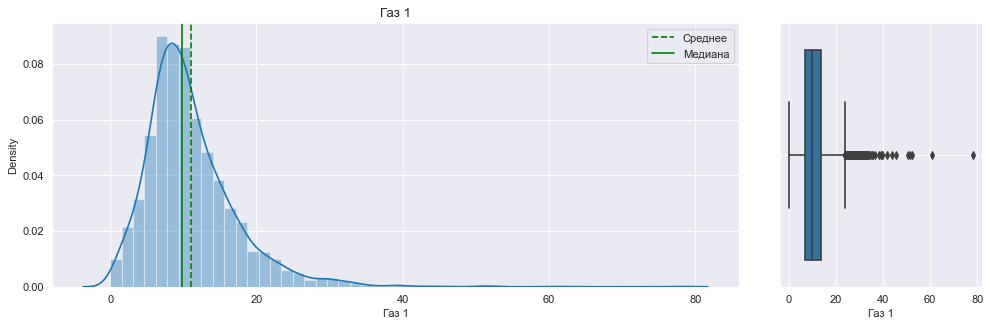

In [21]:
ds.sns_draw(data_gas, 'Газ 1')

In [22]:
# Количество уникальных значений 'key'
len(data_gas['key'].unique())

- Исходя из полученных данных можно сказать, что распределение нормальное
- Дубликатов не имеем, типы данных указаны верно
- Незаполненных значений не имеем

### Data_temp - Результаты измерения температуры;

In [23]:
ds.dataset_info(data_temp)

In [24]:
# Изменим тип данных у времени замера
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [25]:
data_temp.info()

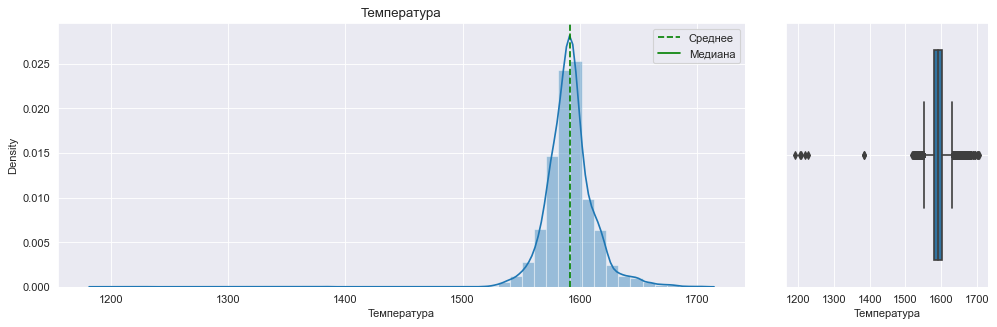

In [26]:
# Посмотрим на распределение температуры
ds.sns_draw(data_temp, 'Температура')

In [27]:
# Посмотрим на пропуски в столбце
data_temp[data_temp['Температура'].isnull()].head(10)

In [28]:
data_temp[data_temp['Температура'].isnull()].tail()

- В датасете отсутствуют некоторые данные по температурам, мы их удалим для дальнейшей работы.
- Распределение выглядит нормальным, но имеются аномальные выбросы
- Начиная с 2500 партии наблюдаем пропущенные значения
- Исправили тип данных у Время замера на datetime
- Дубликатов не имеется

### Data_Wire  -  данные о проволочных материалах (объём);

In [29]:
ds.dataset_info(data_wire)

- Дубликатов нет
- Имеются пустые значения в датасете. Скорее всего, это потому что различные виды проволочных материалов поступали в разных пропорциях в разные промежутки времени
- Типы данных указаны верно

### Data_Wire_time - данные о проволочных материалах (время).

In [30]:
ds.dataset_info(data_wire_time)

- Дубликатов нет
- Имеются пустые значения
- Типы данных в Wire 1 указаны неверно, но менять не будем, так как этот датасет для построения модели использовать не будем

### Вывод по Исследовательскому Анализу Данных

- Загрузили данные, изучили.
- Избавились от некоторых аномальных значений.
- Изменили типы данных, в некоторых датасетах были неправильно указаны данные типа *datetime*
- Проверили данные на пропуски и дубликаты.
- В датасете data_arc ввели сразу новый признак "Полная мощность"
- В таргете отсутствуют данные начиная с 2500-ой партии, далее нужно будет провести срез данных, начиная с 2500 партии


## 2. Предобработка данных

#### План работы:

- Объединим таблицы в один датасет для нашей будущей модели, для более удобной работы
- Обработаем пропуски (заполним или удалим) 
- Целевой признак - Последняя температура 
- Проведём срез данных по Key, начиная с 2500 партии из-за отсутствия нужных данных после

Введём новый признак "Общее время нагрева дугой" для того, чтобы уменьшить количество нужных признаков для построения модели. Так можно будет попробовать увеличить её точность, и просто избавит нас от лишней информации.

In [31]:
# Создадим новый признак "Общее время нагрева дугой", переведем в секунды
data_arc['Общее время нагрева дугой'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['Общее время нагрева дугой'] = data_arc['Общее время нагрева дугой'].dt.seconds

In [32]:
# Поcле 2500 партии значения температуры есть только для первого измерения,
# поэтому будем использовать только партии до 2500 номера
data_temp = data_temp.query('key < 2500')
data_arc = data_arc.query('key < 2500')
data_bulk = data_bulk.query('key < 2500')
data_wire = data_wire.query('key < 2500')

In [33]:
# Определим количество итераций нагрева
data_arc_c = data_arc.groupby(by = 'key', as_index = False).count()[['key', 'Начало нагрева дугой']]
data_arc_c.columns = ['key', 'Количество итераций нагрева']

In [34]:
# Сгруппируем данные по партиям
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()

# Добавим информацию о количестве итераций нагрева по ключу key
data_arc = data_arc.merge(data_arc_c, how = 'left', on = 'key')

In [35]:
# Так как признаки активная и реактивная мощность сильно коррелируют между собой,
# будем использовать только полную мощность
data_arc = data_arc[['key', 'Полная мощность', 'Общее время нагрева дугой', 'Количество итераций нагрева']]

In [36]:
data_arc.head(5)

Посмотрим на корреляцию имеющихся признаков, чтобы понять, стоит ли удалить какие-то ещё из них.

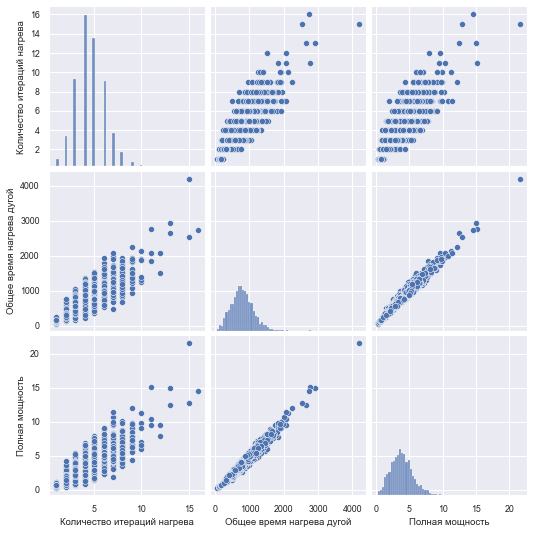

In [37]:
# Построение графика корреляции
plt.figure(figsize=(15,10))
sns.set(font_scale=0.8)
sns.pairplot(data_arc[['Количество итераций нагрева', 'Общее время нагрева дугой', 'Полная мощность']], 
             kind="scatter")
plt.show()

In [38]:
data_arc[['Полная мощность', 'Общее время нагрева дугой', 'Количество итераций нагрева']].corr()

Сильная корреляция между полной мощностью и общим временем нагрева дугой. Избавимся от времени нагрева дугой, не будем использовать этот признак для нашей будущей модели.

In [39]:
# Уберём из датасета столбец "Общее время нагрева дугой"
data_arc = data_arc[['key', 'Полная мощность', 'Количество итераций нагрева']]

In [40]:
data_arc.head(5)

In [41]:
# Очистим пропуски в данных в таблице data_temp
data_temp = data_temp.dropna(subset=['Температура']).reset_index(drop=True)
data_temp = data_temp.sort_values(by=['Время замера'])

In [42]:
# Удалим информацию о партиях по которым известно только одно измерение температуры
count = data_temp.groupby(by = 'key', as_index = False).count()
one = count[count['Время замера'] == 1]['key'].tolist()
data_temp = data_temp.query('key not in @one')

In [43]:
# Сгруппируем данные по партии по первым и последним значениям, последние значения необходимо будет предсказывать
data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'Время замера 1', 'Время замера 2', 'Температура 1', 'Температура 2']
data_temp = data_temp[['key', 'Температура 1', 'Температура 2']]

In [44]:
data_temp.head(5)

#### Объединим данные в одну таблицу

In [45]:
# Объединим обработанные датасеты по ключу key
data = (data_temp.merge(data_arc, how='left', on='key')
                 .merge(data_wire, how='left', on='key')
                 .merge(data_bulk, how='left', on='key')
                 .merge(data_gas, how='left', on='key')
       )


# Заполним пропуски образовавшиеся после объединения таблиц нулями
data = data.fillna(0)

# Переименуем столбцы для корректной работы LightGBM
data = data.rename(columns={'Температура 1': 'First_temp',
                            'Температура 2': 'Last_temp',
                            'Полная мощность': 'Full_power',
                            'Количество итераций нагрева': 'Heating_iterations',
                            'Газ 1': 'Gas'}
                  )

# Уберём столбец key, который мы использовали для объединения датасетов
data = data.drop(['key'], axis = 1)

In [46]:
data.head(5)

In [47]:
data.info()

Теперь, подготовим данные к обучению модели. Сначала разделим датасет на обучающую и тестовую выборки, а потом займёмся масштабированием признаков. Масштабирование нужно проводить из-за того, что признаки показывают разные единицы, и покрывают из-за этого разные диапазоны. Нам нужно привести это всё "к одному".

In [48]:
# Разделим нашу выборку на тестовую и обучающую
train, test = train_test_split(data, test_size=.30, random_state=SEED)

In [49]:
train.columns

В нашей таблице имеются количественные признаки с разными разбросами, поэтому проведем масштабирование признаков

In [50]:
# Масштабируем количественные признаки
numeric = data.columns.tolist()
numeric = [i for i in numeric if i not in ('Last_temp')]
scaler = MinMaxScaler()
scaler.fit(train[numeric])

# Масштабируем обучающую и тестовую выборку
train[numeric] = scaler.transform(train[numeric])
test[numeric] = scaler.transform(test[numeric])

In [51]:
print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выобрки:', test.shape)

In [52]:
train.head(5)

### Вывод по Предобработке данных

- Избавились от выбросов и пустых значений, ненужных признаков
- Соединили таблицы в одну итоговую таблицу для удобства построения модели
- Подготовили датасет, разделили его на обучающую и тестовую выборки, провели масштабирование признаков

## 3. Обучение моделей и подбор параметров

Целевой признак нашей модели — последняя температура (стали), он находится в столбце 'Last_Temp'. Его и должна будет предсказывать модель.

Далее, мы разделим датасеты: тренировочный (на котором будет обучаться модель) и тестовый (на котором мы будем проверять её) на целевой признаки и остальные, после чего будем подбирать наилучшую модель из четырёх выбранных: CatBoostRegressor, LGBMRegressor, XGBRegressor, LinearRegression. Они предсказывают численные значения, обучаются достаточно быстро и имеют сравнительно высокую точность. 

Для них будут подбираться наилучшие параметры, измерять качество модели будем при помощи метрики MAE (mean absolute error/средняя абсолютная ошибка). Чем меньше значение этой метрики, тем лучше.

In [53]:
# Определим признаки и целевой признак для выборок
features_train = train.drop(['Last_temp'], axis = 1)
target_train = train['Last_temp']

features_test = test.drop(['Last_temp'], axis = 1)
target_test = test['Last_temp']

In [54]:
# Модели, которые будет использовать для подбора наилучшей

models = {
    'CatBoostRegressor': CatBoostRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'XGBRegressor': xgboost.XGBRegressor(),
    'LinearRegression': LinearRegression()
}


# Параметры для каждой модели, которые мы будем подбирать для определения лучшей
params = {
    'CatBoostRegressor':{
          'loss_function':['MAE'],
          'n_estimators': np.arange(300, 700, 100),  
          'learning_rate': np.arange(0.03, 0.12, 0.02),
          'random_state':[17],
          'depth': np.arange(3, 7)
    },        

    'LinearRegression':{
            'fit_intercept' : [True, False],
            'normalize':[True,False]
    },
    
    
    'LGBMRegressor': {
        'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
        'objective': ['regression'],
        'learning_rate': [0.001, 0.01, 0.02, 0.03],
        'num_iterations':[500],
        'random_state': [42], 
        'max_depth': np.arange(2, 10),
        'metric': ['mae']
        },

    
    'XGBRegressor': {
        'min_child_weight': [10,20,30],
        'gamma': [5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5,10,20],
        'eval_metric' :['mae']
        }
}

In [55]:
%%time
result_list = []
ds.fit(features_train, target_train)

In [56]:
# Выведем наилучшие подобранные параметры
result_list

In [57]:
# Сохраним всё в таблицу
results = pd.DataFrame(result_list, columns=['model','train_mae_score','test_mae_score','best_params'])
results.set_index("model", inplace = True)

In [58]:
results

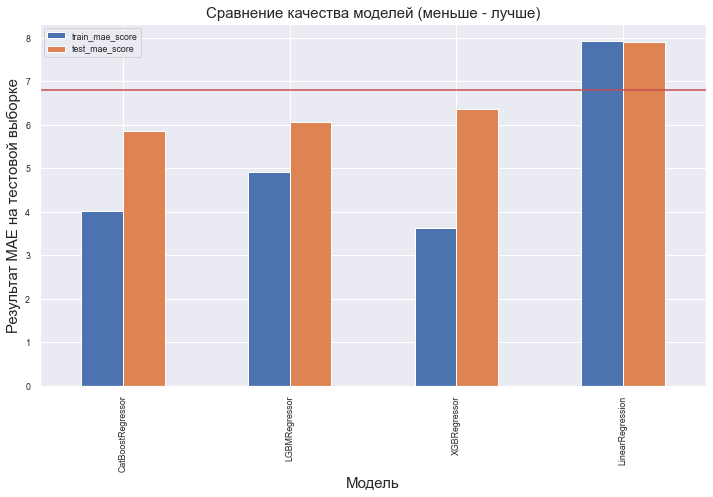

In [59]:
# Посмотрим на MAE на обучающей и тестовой выборках
plt.figure(figsize=(10, 7))
plt.subplot(111)
results.plot(kind='bar', ax=plt.gca()).hlines(6.8, -1, 5, color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('Результат MAE на тестовой выборке', fontsize=15)
plt.title('Сравнение качества моделей (меньше - лучше)', fontsize=15)
plt.tight_layout()

Итог:

- Провели подбор параметров к четырём разным моделям: CatBoostRegressor, LGBMRegressor, XGBRegressor и LinearRegression
- Наилучшие результаты получили у CatBoostRegressor с MAE 5.8 на тестовой выборке
- У LiGBMRegressor и XGBRegressor по ~6 MAE на тестовой выборке
- Хуже всего показала результат модель LinearRegression с результатом 7.8 на тестовой выборке

### Финальная модель на тестовой выборке с наилучшими параметрами

In [60]:
# С подобранными параметрами будем использовать модель CatBoostRegressor на тестовой выборке
model = CatBoostRegressor(depth=4, 
                          learning_rate = 0.11000000000000001, 
                          loss_function = 'MAE', 
                          n_estimators = 600, 
                          random_state = 17,
                          verbose = 0)

model.fit(features_train,target_train)
predictions = model.predict(features_test)
print('MAE на тестовой выборке:', mean_absolute_error(predictions,target_test))

### Feature Importance

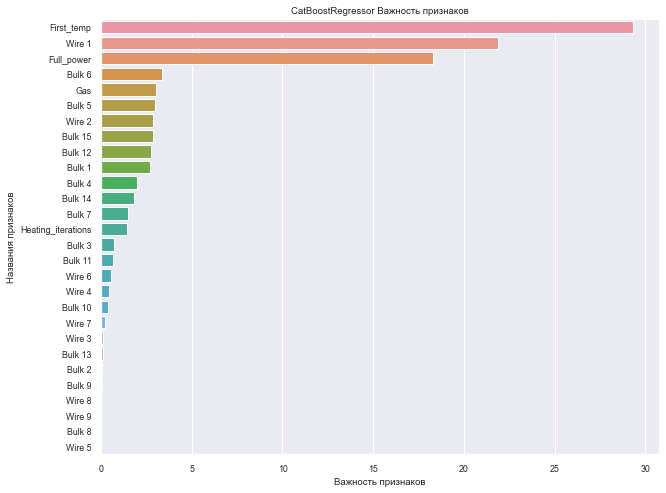

In [61]:
# Посмотрим график важности признаков у модели
ds.feature_importance_plot(model.feature_importances_,features_test.columns,'CatBoostRegressor ')

Мы провели финальное тестирование нашей модели. Модель показала результат MAE около 5.8 на тестовой выборке, что соответствует условию решения задачи.

## Общий вывод

По плану работы, все пункты были успешно выполнены. Данные были загружены, исследовательский анализ данных проведён, и была проведена предобработка данных с последующим подбором наилучшей модели, которую мы нашли и проверили на тестовой выборке.

Главная трудность была в том, что нужно было определить целевой признак модели, от значения которого зависило бы потребление энергии. В качестве целевого признака был выбран столбец "Последняя температура", так как если температура стали будет сильно выше оптимального значения, то много энергии уйдёт "впустую", а у нас стоит задача уменьшить энергопотребление.

Мы провели исследовательский анализ данных и устранили аномальные значения, выбросы. Выяснилось, что имеется сильная корреляция между признаками "Активная мощность" и "Реактивная мощность", поэтому мы ввели новый признак — "Полная мощность", вычисленный при помощи этих двух признаков.

Затем, провели предобработку данных: обработали пропуски, добавили несколько новых признаков для нашей модели, некоторые из которых пришлось позже удалить из-за сильной корреляции между ними (удалили введённый признак "Общее время нагрева дугой", оставили признак "Полная мощность". 

Провели масштабирование признаков для приведения их к одним "единицам", из-за чего должна повыситься точность модели. Алгоритмы машинного обучения работают лучше, если данные привести в одинаковый "масштаб"


Для обучения использовали 4 модели: CatBoostRegressor, LightGBMRegressor, XGboostRegressor, LinearRegression. После подбора параметров с помощью метода GridSearchCV, CatBoostRegressor оказалась наиболее точной моделью, с метрикой MAE около 5.8, тогда как худшей оказалась модель LinearRegression с MAE около 7.8. 

Также, были выявлены признаки, которые больше всего влияют на предсказания модели. Это "Начальная температура", "Wire 1" и "Полная мощность".

Таким образом, CatBoostRegressor, как наиболее точная полученная модель, будет лежать в основе модели предсказания температуры.